### Notebook to visualize/compute results of local principal estimator

### Procedure of protocol
1. Visualize selected images
2. Summarize angle to Wind Rose plot

In [1]:
%matplotlib inline 
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
from PIL import Image

In [2]:
from sklearn.cluster import KMeans

In [2]:
## download plotly
!pip install plotly

     |████████████████████████████████| 11.5MB 15.1MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-cp36-none-any.whl size=11429 sha256=9bb71ad0597fc10f03763749a50ad0e752cf83a6f3d58f28fe095b6d9febfcea
  Stored in directory: /home/tkurihana/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [57]:
!pip install psutil

     |████████████████████████████████| 450kB 10.5MB/s eta 0:00:01
  Created wheel for psutil: filename=psutil-5.7.0-cp36-cp36m-linux_x86_64.whl size=272792 sha256=2564a15eb7575a49180050c624478a35558cabebd1e1d8d445eec0fb07114921
  Stored in directory: /home/tkurihana/.cache/pip/wheels/d7/69/b4/3200b95828d1f0ddb3cb5699083717f4fdbd9b4223d0644c57
Successfully built psutil


In [3]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [4]:
import plotly.offline as po
import plotly.io as pio

In [5]:
def result_loader(basedir, basename=None, nfiles=10, index_list=None):
    """ File: fig_clustering_low-m2_02_global_2000_2018_band28_29_31_gray_n-0_N-20.jpg
    """
    imgs_list = []
    #for i in range(nfiles):
    for i in index_list:    
        file = (os.path.join(basedir,
            "fig_clustering_low-{}_gray_n-{}_N-20.jpg".format(
                    basename, i
                )
            )
        )
        
        img = Image.open(file)
        imgs_list.append(img)
    return imgs_list

In [6]:
def log_loader(basedir,basename=None, nfiles=10, index_list=None):
    data_list = []
    
    files = glob.glob(os.path.join(basedir,"*.txt"))
    print(len(files))
    #for i in range(nfiles):
    #for i in index_list: 
        
    for file in files:  
        with open(file, 'r') as f:
            lines = f.read()
            data = []
            for line in lines.split('\n'):
                #print(line)
                j = line.replace(' ', '')
                if len(j) > 0:
                    data.append(float(j))
        data_list.append(np.array(data))
    return data_list

--------------
### 1. Visualizarion  
Visualize top K labeld images

Load encoded low dimension manifold

In [7]:
encoded_datadir='/home/tkurihana/Research/rotate_invariant/stepbystep/transform/protocol/encodings'

In [8]:
def load_encodings(datadir, expname, tfname='tfrecord-2-10', kernel=1):
    return np.load(
        os.path.join(datadir,
            "encoding_exp-"+str(expname)+"_kernel-1_"+str(tfname)+".npy"
        )
    )

In [9]:
expnames = [67011582, 'm2_02_global_2000_2018_band28_29_31' ]

In [10]:
encoded_list = []
for expname in expnames:
    encoded_list.append(load_encodings(encoded_datadir, expname))

Get clustering assignments

In [11]:
def comp_protocol_table(data_basedir='./',expname='0000',kernel_list=[], base_kernel=1,tfname='0-0',ncluster=10):
    """ kernel_list [2,3,....] not include 1 pixel
    """
    baseline = np.load(os.path.join(
                        data_basedir+'/'+expname,
                        "clr-sklaggl__nc-"+str(ncluster)+"_kernel1_tfrecord-"+tfname+".npy"
                    )
                )
    # MOSAIC: "clr-sklaggl__kernel1_tfrecord-"+tfname+".npy"
    #"clr-sklaggl__nc-"+str(ncluster)+"_kernel1_tfrecord-"+tfname+".npy"
    print(f'check array shape {baseline.shape}')
    return baseline

In [12]:
expnames = [67011582, 'm2_02_global_2000_2018_band28_29_31' ]

In [13]:
cluster_basedatadir = '/home/tkurihana/Research/rotate_invariant/stepbystep/transform/protocol/clustering'

In [14]:
nclusters = 20

In [15]:
#2-10 * holdoutset
results_list = []
for expname in expnames:
    result = comp_protocol_table(data_basedir=cluster_basedatadir,
                                 expname=str(expname), kernel_list=1,tfname='2-10',ncluster=nclusters)
    results_list.append(result)

check array shape (2000,)
check array shape (2000,)


Approximate centroid

In [16]:
def compute_centroid(features):
    """ approximate centorid by kmeans
    """
    kmeans = KMeans(n_clusters=1, init='k-means++', n_init=10, max_iter=300,
                       tol=0.0001,precompute_distances='auto', verbose=0,
                       random_state=None, copy_x=True, n_jobs=4)
    pred = kmeans.fit_predict(features)
    center = kmeans.cluster_centers_
    return center 

In [17]:
centroids_list = []
for edx, expname in enumerate(expnames):
    centroids = []
    for cluster in range(nclusters):
        index = np.where(results_list[edx] == cluster)
        _features = encoded_list[edx][index]
        npatches, nh,nw,nc = _features.shape
        features = _features.reshape(npatches, nh*nw*nc)
        centroids.append(compute_centroid(features))
    centroids_list.append(centroids)
    print(f"Finish {expname} | # of cluster = {nclusters}")

Finish 67011582 | # of cluster = 20
Finish m2_02_global_2000_2018_band28_29_31 | # of cluster = 20


Compute distance in low embedding

In [18]:
def compute_distMatrix(data,center):
    """ data[np, nw*nh*nc] 
        center[nw*nh*nc]
        distance := L2 (default)
    """
    #print(data.shape, center.shape)
    dist = np.sqrt(np.sum((data - center)**2, axis=-1),)
    #print(dist.shape)
    sort_index = np.argsort(dist,axis=0) 
    return sort_index, dist

In [19]:
dists_list = []
sortIndex_list = []
for edx, expname in enumerate(expnames):
    dists = []
    sortIndex = []
    for cluster in range(nclusters):
        index = np.where(results_list[edx] == cluster)
        _features = encoded_list[edx][index]
        npatches, nh,nw,nc = _features.shape
        features = _features.reshape(npatches, nh*nw*nc)
        sort_index, dist_matrix = compute_distMatrix(features, centroids_list[edx][cluster])
        dists.append(dist_matrix)
        sortIndex.append(sort_index)
    dists_list.append(dists)
    sortIndex_list.append(sortIndex)
    print(f"Finish {expname} | # of cluster = {nclusters}")

Finish 67011582 | # of cluster = 20
Finish m2_02_global_2000_2018_band28_29_31 | # of cluster = 20


##### Collect top K figures for visualization

In [20]:
basedir = '/home/tkurihana/Research/Paxis/protocol'

In [21]:
def img_preprocess(imgs_list, lurl=(180, 25, 770, 550) ):
    preprocess_list = []
    for img in imgs_list:
        tmp = img.crop(lurl)
        preprocess_list.append(np.asarray(tmp))
    return preprocess_list

In [22]:
def collection_fn(basedir, results, sort_index, nclusters=None, topK=None, expname=None, preprocess=False):
    imgs_list = []
    for cluster in range(nclusters):
        tmp_list = []
        select_index = sort_index[cluster][:topK]
        
        figdir = os.path.join(
            basedir, 'results/'+'{}'.format(expname)+'/'+'cluster-{}_N-{}'.format(cluster, nclusters)
        )
        #for num in select_index:
            # 
        img = result_loader(figdir, basename=expname, index_list=select_index)
        if preprocess:
            tmp_list.append(img_preprocess(img))
        else:
            tmp_list.append(img)
        
        imgs_list.append(tmp_list)
    return imgs_list

In [23]:
topK = 10

- 67011582

In [51]:
imgs_ri_list = collection_fn(basedir, results=results_list[0], sort_index=sortIndex_list[0], 
              nclusters=nclusters, topK=topK, expname=expnames[0],preprocess=True)

In [50]:
def base_plot(imgs_list, size=(4,3),dpi=100, nrow=2, ncol=5, expname=None):
    fig,ax  = plt.subplots(ncol, nrow,figsize=size,dpi=dpi)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    for icol, tmp_imgs_list in enumerate(imgs_list):
        #print( len(tmp_imgs_list[0]) )
        for ii,i in enumerate(range(len(tmp_imgs_list[0]))) :
            ax[ii][icol].imshow(tmp_imgs_list[0][i])
            ax[ii][icol].set_xticklabels([])
            ax[ii][icol].set_yticklabels([])
            ax[ii][icol].axis('off')
    fig.tight_layout()
    #plt.show()
    plt.savefig('./all_{}_N-{}.png'.format(expname, len(imgs_list)))
    plt.close()

In [52]:
base_plot(imgs_ri_list, size=(40,20), dpi=200, nrow=20,ncol=10, expname=expnames[0])

- 'm2_02_global_2000_2018_band28_29_31' 

In [54]:
imgs_nori_list = collection_fn(basedir, results=results_list[1], sort_index=sortIndex_list[1], 
              nclusters=nclusters, topK=topK, expname=expnames[1],preprocess=True)

In [55]:
base_plot(imgs_nori_list, size=(40,20), dpi=200, nrow=20,ncol=10)

In [152]:
for i in sortIndex_list:
    for cluster in range(nclusters):
        print(cluster, i[cluster][:topK] )

0 [18 21 23 20 17  8 13 24 14 12]
1 [11 13 29 30 17 12 23  9 25  8]
2 [380  98 103  81  85 379  76 252  91  80]
3 [ 19  52   8 139  44  56 128 115  51  22]
4 [16 10 18 21 17 23 19 22 25 13]
5 [20 19 31 17 23 32 30  5 33  3]
6 [32 31 27 30 17 19 20 16 21 26]
7 [42 22 43 15 24 20 18 25 38 27]
8 [14 26 28 27  9 16 19 20 17 13]
9 [ 3  2 23 24 37 31 26  0 22 69]
10 [35 25 71 73 45 34 70 24 16 26]
11 [ 1  3  5 22  6  2  4 10 16  7]
12 [50 52 49 91 48 56 51 53 58  2]
13 [ 81  80 156 163 189 222 306  79 177 272]
14 [ 6 11  8  9  4  3 15 21 18 12]
15 [ 4  8  7 34  6  3 20 17 13 12]
16 [26 20 19 67 31 23 34 21 16 22]
17 [76  4 73 54  1 33 40 38  3 31]
18 [ 35  34  32 100  37 146   4 140  36 130]
19 [44 75 85 17 16 43 81  9 74 83]
0 [31 27 25 34 29 28  0 30 32 43]
1 [ 67  66  74 164 245 253 163  76 235 258]
2 [23 12 18  6 17 13 11 28 20  7]
3 [64 62 44 67 63 60 68 69 61 49]
4 [39 14 16 34 18 35 29 17 20 36]
5 [15 14 22 18 20 32 21 24 26 16]
6 [ 66  57  68  71 113  26 114  17  67  72]
7 [77 39 51 

-------------
### Wind Rose

In [24]:
def compute_dfangle(basedir, results, sort_index, nclusters=None, topK=None, expname=None, preprocess=False, nangle=16, debug=False):
    logs_list = []
    dcheck_list = [] # for debug with matplotlib
    for cluster in range(nclusters):
        tmp_list = []
        logdir = os.path.join(
            basedir, 'logs2/'+'{}'.format(expname)+'/'+'cluster-{}_N-{}'.format(cluster, nclusters)
        ) 
        logs = log_loader(logdir, basename=expname, nfiles=len(sort_index) )
        
        tmp_list = []
        for log in logs:
            # mode
            md = mode(log)
            #print(md[0])
            tmp_list.extend(md[0])
            
            # mean
            #tmp_list.append(np.mean(log))
        dcheck_list.append(tmp_list)
        
        # dataframe
        angles = []
        ag = np.linspace(0,360,nangle)
        amax = 360+ag[1]
        for idx, i in enumerate(ag[:-1]):
            tmp = list(filter(lambda x : x  > ag[idx] and x <= ag[idx+1], tmp_list))
            angles.append(len(tmp))
        df = pd.DataFrame(np.array(angles))
        df.columns = ['frequency']
        df['theta'] = np.array([ float((i+ag[idx+1])/2) for idx, i in enumerate(ag[:-1])])
        
        logs_list.append(df)
    
    if debug:
        return logs_list, dcheck_list
    else:
        return logs_list

- RI

In [24]:
logs_ri_list = compute_dfangle(basedir, results=results_list[0], sort_index=sortIndex_list[0], 
              nclusters=nclusters, topK=topK, expname=expnames[0],preprocess=True, nangle=15)

24
37
414
152
47
33
32
52
29
77
84
25
108
341
25
65
73
116
162
85


In [25]:
_, dist_ri_list = compute_dfangle(basedir, results=results_list[0], sort_index=sortIndex_list[0], 
              nclusters=nclusters, topK=topK, expname=expnames[0],preprocess=True, nangle=15, debug=True)

24
37
414
152
47
33
32
52
29
77
84
25
108
341
25
65
73
116
162
85


In [28]:
from pylab import *
from matplotlib.colors import Colormap
def get_colors(n=-1, cmap_name='jet'):
    # colormap
    cmap = cm.get_cmap(cmap_name, n)
    colors = []
    for idx, i in enumerate(range(cmap.N)):
        rgb = cmap(i)[:3]
        #print(idx, matplotlib.colors.rgb2hex(rgb))
        colors += [matplotlib.colors.rgb2hex(rgb)]
    return colors

In [ ]:
# mode
## TODO: Should be debug
colors =get_colors(n=nclusters, cmap_name='jet')
for cluster in range(nclusters):
#for cluster in range(1):
    fig = go.Figure()
    fig.add_trace(go.Barpolar(
        r=logs_ri_list[cluster],
        name='{}'.format(cluster),
        marker_color='{}'.format(colors[cluster])
    ))
    fig.update_layout(
    title='Pincipal Axis Distribution {}'.format(cluster),
    font_size=16,
    legend_font_size=16,
    polar_radialaxis_ticksuffix='%',
    polar_angularaxis_rotation=90,

    )

    fig.show()
    #fig.close()

In [40]:
# DF: mode
#colors =get_colors(n=nclusters, cmap_name='jet')
for cluster in range(nclusters):
    df = logs_ri_list[cluster]
    fig = px.bar_polar(df, r="frequency", theta="theta", color="frequency", template="plotly_white",
            color_discrete_sequence= px.colors.sequential.Plasma_r)
    fig.update_layout(
    title_text="".format(cluster) )
    fig.show()
    #fig.close()

-----------------
###### Attempt to make-fig $\rightarrow$ save fig: 
There is an error for write_image method. Maybe conflict between conda and pip?

In [30]:
import plotly.io as pio

In [34]:
from plotly.subplots import make_subplots

In [58]:
from plotly.offline import init_notebook_mode, plot_mpl

In [60]:
# DF: mode
sdir = "./figs/rosewind/{}".format(expnames[0])
os.makedirs(sdir, exist_ok=True)
init_notebook_mode()
for cluster in range(nclusters):
    df = logs_ri_list[cluster]
    fig = px.bar_polar(df, r="frequency", theta="theta", color="frequency", template="plotly_white",
            color_discrete_sequence= px.colors.sequential.Plasma_r),
            
    plot_mpl(fig)
    plt.savefig(os.path.join(sdir, "figall_{}_N-{}.png".format(cluster, nclusters)))
#fig.show()

AttributeError: 'tuple' object has no attribute 'canvas'

---------------

######  Practice/Debug matplotlib plt.bar in polar projection

In [44]:
df = logs_ri_list[0]

In [69]:
np.linspace(0,360,15)

array([  0.        ,  25.71428571,  51.42857143,  77.14285714,
       102.85714286, 128.57142857, 154.28571429, 180.        ,
       205.71428571, 231.42857143, 257.14285714, 282.85714286,
       308.57142857, 334.28571429, 360.        ])

In [45]:
df['theta'], df['frequency']

(0      12.857143
 1      38.571429
 2      64.285714
 3      90.000000
 4     115.714286
 5     141.428571
 6     167.142857
 7     192.857143
 8     218.571429
 9     244.285714
 10    270.000000
 11    295.714286
 12    321.428571
 13    347.142857
 Name: theta, dtype: float64, 0     3
 1     4
 2     4
 3     8
 4     2
 5     0
 6     3
 7     0
 8     0
 9     0
 10    0
 11    0
 12    0
 13    0
 Name: frequency, dtype: int64)

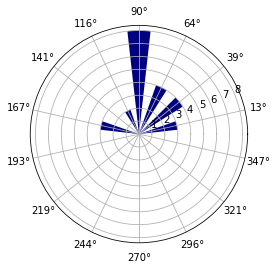

In [85]:
plt.figure()
for cluster in [0]:
    ax = plt.subplot(111, projection='polar')
    width = 1*(2*np.pi/28) #np.pi / 16
    df = logs_ri_list[cluster]
    theta = df['theta'].values
    radii = df['frequency'].values
    #width = np.pi / 15
    colors = mycolors[cluster]

    #ax = plt.subplot(111, projection='polar')
    a = ax.bar(theta*np.pi/180, radii, width=width, bottom=0.0, color=colors, alpha=1)
    ###
    # <---------- need to be re-converted to radian from degree
    ###
    
    
    s = np.linspace(0,360,15)
    ss = [float((i+s[idx+1])/2) for idx,i in enumerate(s[:-1])]
    ax.set_thetagrids(ss)
    
    #ax = plt.subplot(111, projection='polar')
    #ax.bar([jj*10*np.pi/180 for jj in range(len(radii))], radii, width=width, bottom=0.0, color=colors, alpha=1)
    
#print(a)

------------------

###### matplotlib All-in-One figure for rose-wind

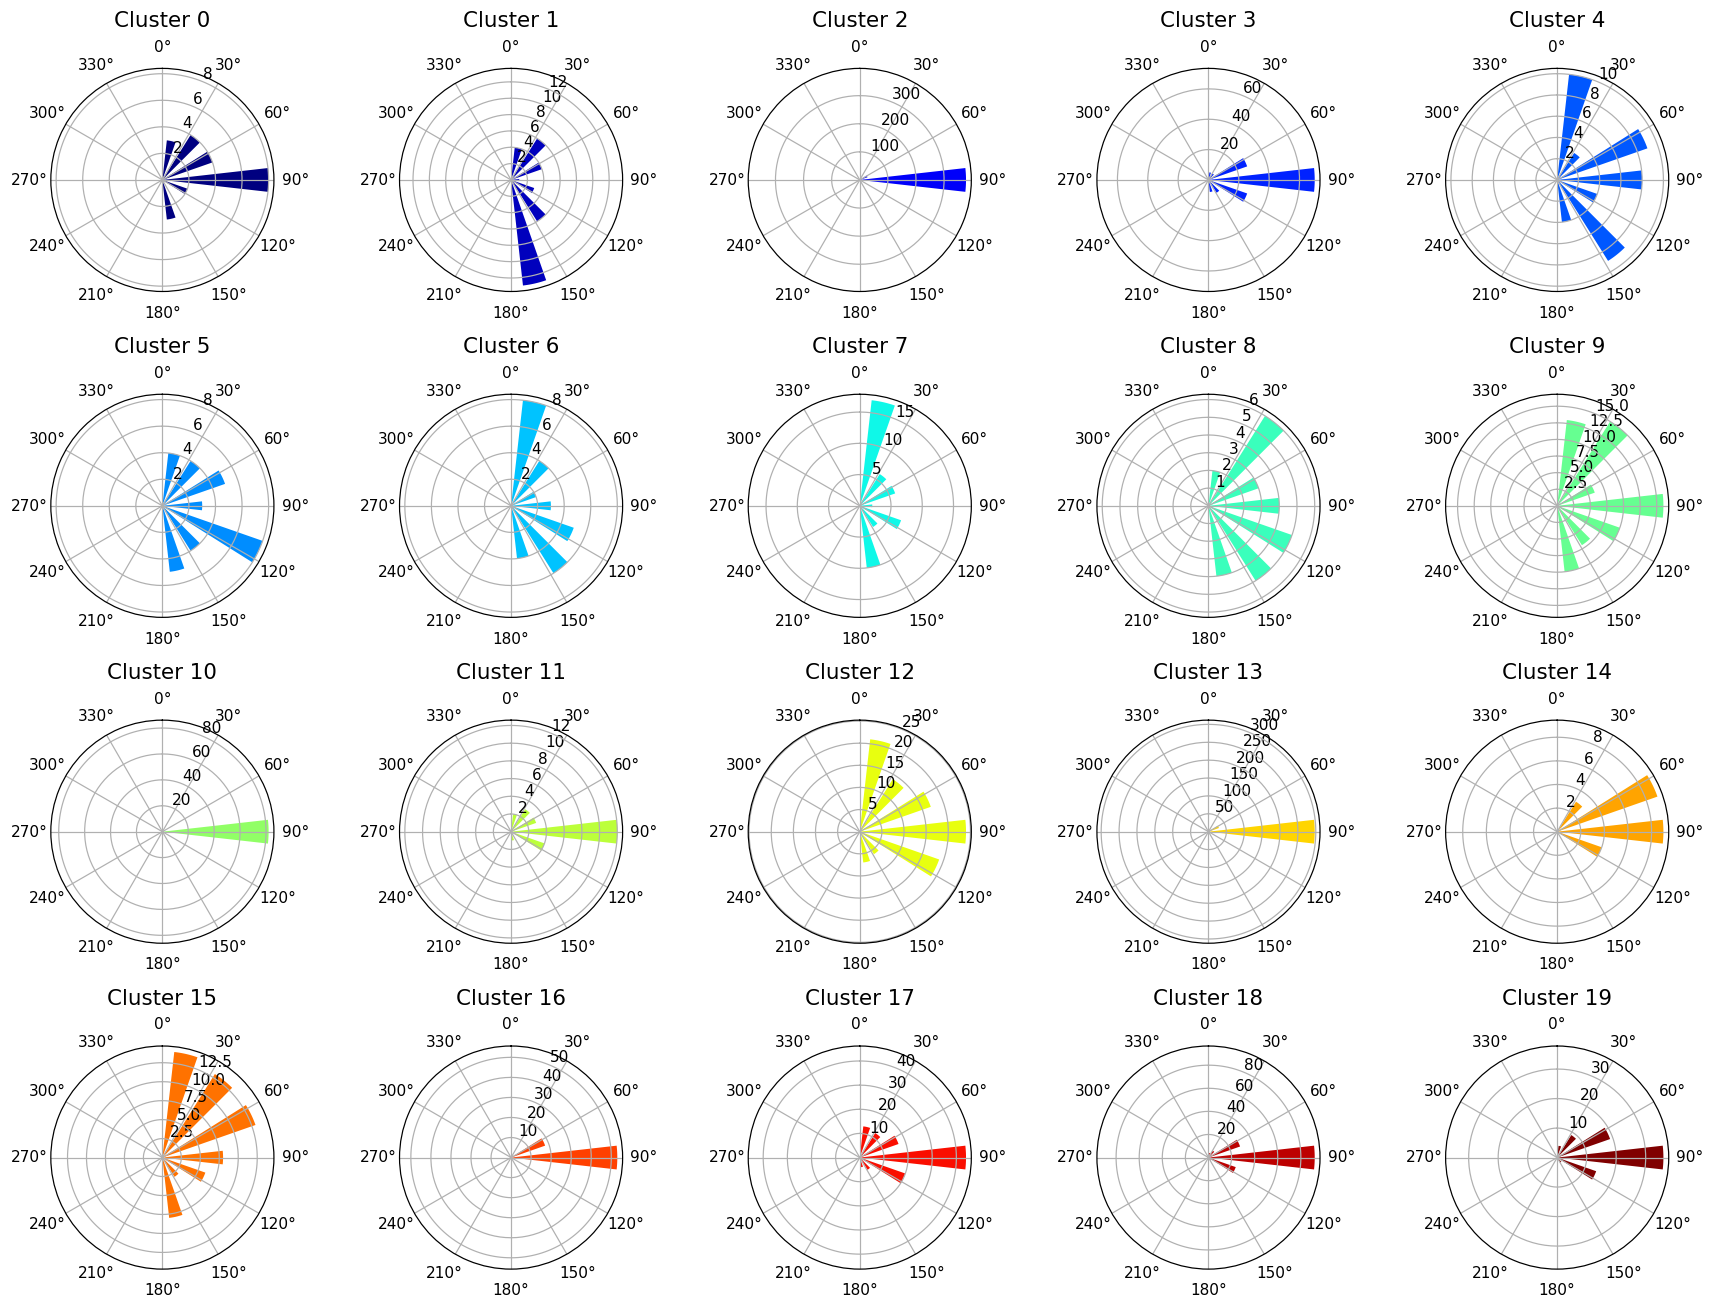

In [31]:
# Compute pie slices
mycolors =get_colors(n=nclusters, cmap_name='jet')
fig = plt.figure(figsize=(16,12), dpi=110)
for cluster in range(nclusters):
    idx = cluster + 1
    ax = plt.subplot(4,5,idx, projection='polar')
    width = 1*(2*np.pi/28) #np.pi / 16
    df = logs_ri_list[cluster]
    theta = df['theta'].values
    radii = df['frequency'].values
    colors = mycolors[cluster]

    #ax = plt.subplot(111, projection='polar')
    ax.bar(theta*np.pi/180, radii, width=width, bottom=0.0, color=colors, alpha=1)
    
    ax.set_title("Cluster {}".format(cluster),fontsize=14, pad=20)
    ax.set_thetagrids(range(0, 360, 30))
    ax.set_theta_zero_location('N')  # set direction of zero
    ax.set_theta_direction(-1) # set rotation as clockwise
fig.tight_layout()
plt.show()

###### check distribution.

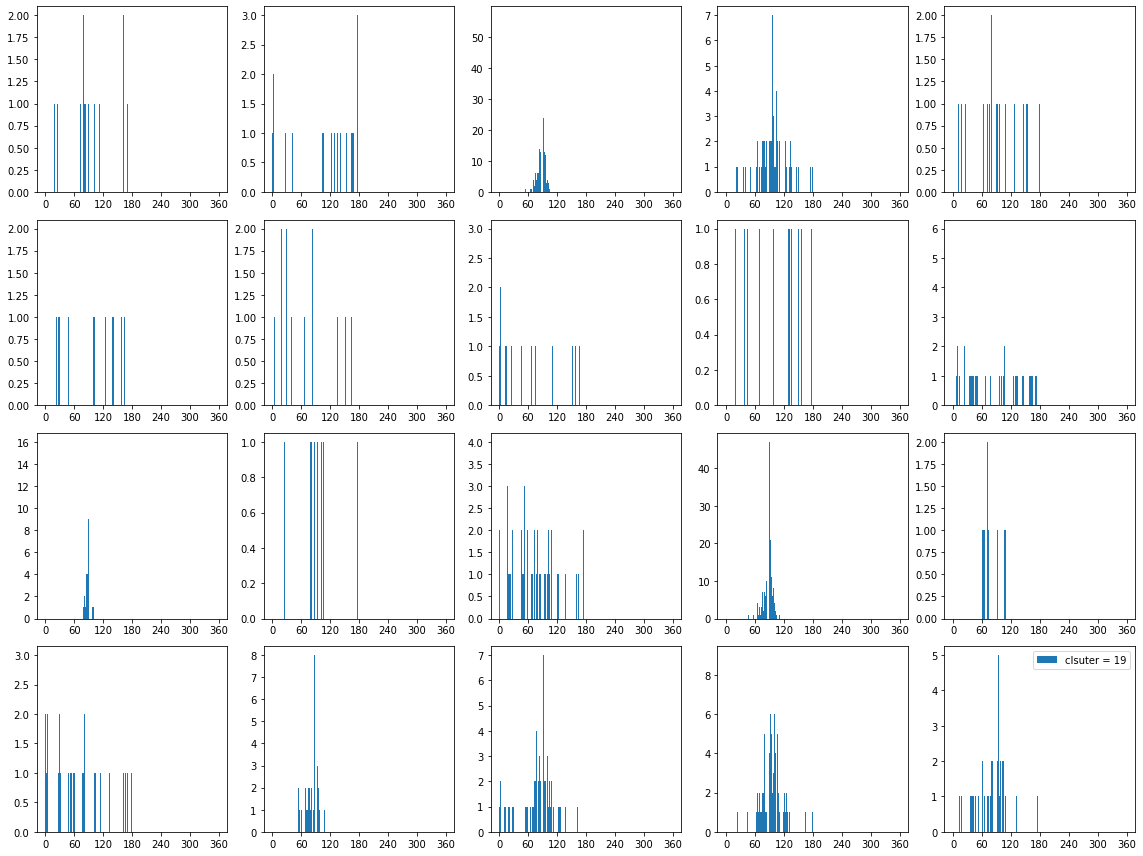

In [35]:
fig = plt.figure(figsize=(16,12))
for cluster in range(nclusters):
    idx = cluster + 1
    ax = plt.subplot(4,5,idx)
    plt.hist(dist_ri_list[cluster], bins=np.linspace(0,360,361), label="clsuter = {}".format(cluster), rwidth=0.8)
    ax.set_xticks(np.linspace(0,360,7))
plt.legend()
fig.tight_layout()
plt.show()

------------
###### Debug check 07/06. Whether there are items larger than 180 degree

In [26]:
def debug_compute_dfangle(basedir, results, sort_index, 
                          nclusters=None, topK=None, expname=None, preprocess=False, nangle=16, debug=False):
    logs_list = []
    for cluster in range(nclusters):
        tmp_list = []
        logdir = os.path.join(
            basedir, 'logs2/'+'{}'.format(expname)+'/'+'cluster-{}_N-{}'.format(cluster, nclusters)
        ) 
        logs = log_loader(logdir, basename=expname, nfiles=len(sort_index) )
        for log in logs:
            logs_list.extend(log)
    return logs_list

In [47]:
dlog_ri_list = debug_compute_dfangle(basedir, results=results_list[0], sort_index=sortIndex_list[0], 
              nclusters=nclusters, topK=topK, expname=expnames[0],preprocess=True, nangle=15, debug=True)

24
37
414
152
47
33
32
52
29
77
84
25
108
341
25
65
73
116
162
85


In [48]:
dlog_ri_list = debug_compute_dfangle(basedir, results=results_list[0], sort_index=sortIndex_list[0], 
              nclusters=nclusters, topK=topK, expname=expnames[0],preprocess=True, nangle=15, debug=True)

24
37
414
152
47
33
32
52
29
77
84
25
108
341
25
65
73
116
162
85


(array([8.530e+02, 5.400e+02, 6.040e+02, 8.110e+02, 6.730e+02, 9.350e+02,
        1.190e+03, 2.186e+03, 7.852e+03, 9.028e+03, 2.506e+03, 1.030e+03,
        7.900e+02, 5.500e+02, 4.290e+02, 4.070e+02, 6.200e+02, 6.760e+02,
        1.000e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
        330., 340., 350., 360.]),
 <a list of 36 Patch objects>)

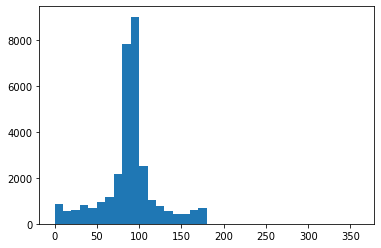

In [49]:
plt.hist(dlog_ri_list, bins=np.linspace(0,360,37))

------------------------

- No RI

In [26]:
logs_nori_list = compute_dfangle(basedir, results=results_list[1], sort_index=sortIndex_list[1], 
              nclusters=nclusters, topK=topK, expname=expnames[1],preprocess=True, nangle=15)

70
320
29
72
39
33
125
100
176
64
65
250
201
46
62
118
110
39
29
32


In [ ]:
# mode
colors =get_colors(n=nclusters, cmap_name='jet')
for cluster in range(nclusters):
#for cluster in range(1):
    fig = go.Figure()
    fig.add_trace(go.Barpolar(
        r=logs_nori_list[cluster],
        name='{}'.format(cluster),
        marker_color='{}'.format(colors[cluster])
    ))
    fig.update_layout(
    title='Pincipal Axis Distribution {}'.format(cluster),
    font_size=16,
    legend_font_size=16,
    polar_radialaxis_ticksuffix='%',
    polar_angularaxis_rotation=90,

    )

    fig.show()
    #fig.close()

In [43]:
# DF: mode
for cluster in range(nclusters):
    df = logs_nori_list[cluster]
    fig = px.bar_polar(df, r="frequency", theta="theta", color="frequency", template="plotly_white",
            color_discrete_sequence= px.colors.sequential.Plasma_r)
    fig.show()
    #fig.close()

In [ ]:
# DF: mode
sdir = "./figs/rosewind/{}".format(expnames[1])
os.makedirs(sdir, exist_ok=True)
for cluster in range(nclusters):
    df = logs_nori_list[cluster]
    fig = px.bar_polar(df, r="frequency", theta="theta", color="frequency", template="plotly_white",
            color_discrete_sequence= px.colors.sequential.Plasma_r)
    fig.write_image(os.path.join(sdir, "rfig_{}.png".format(cluster)))
    #fig.close()

###### All-in-One for no-rotation invariant

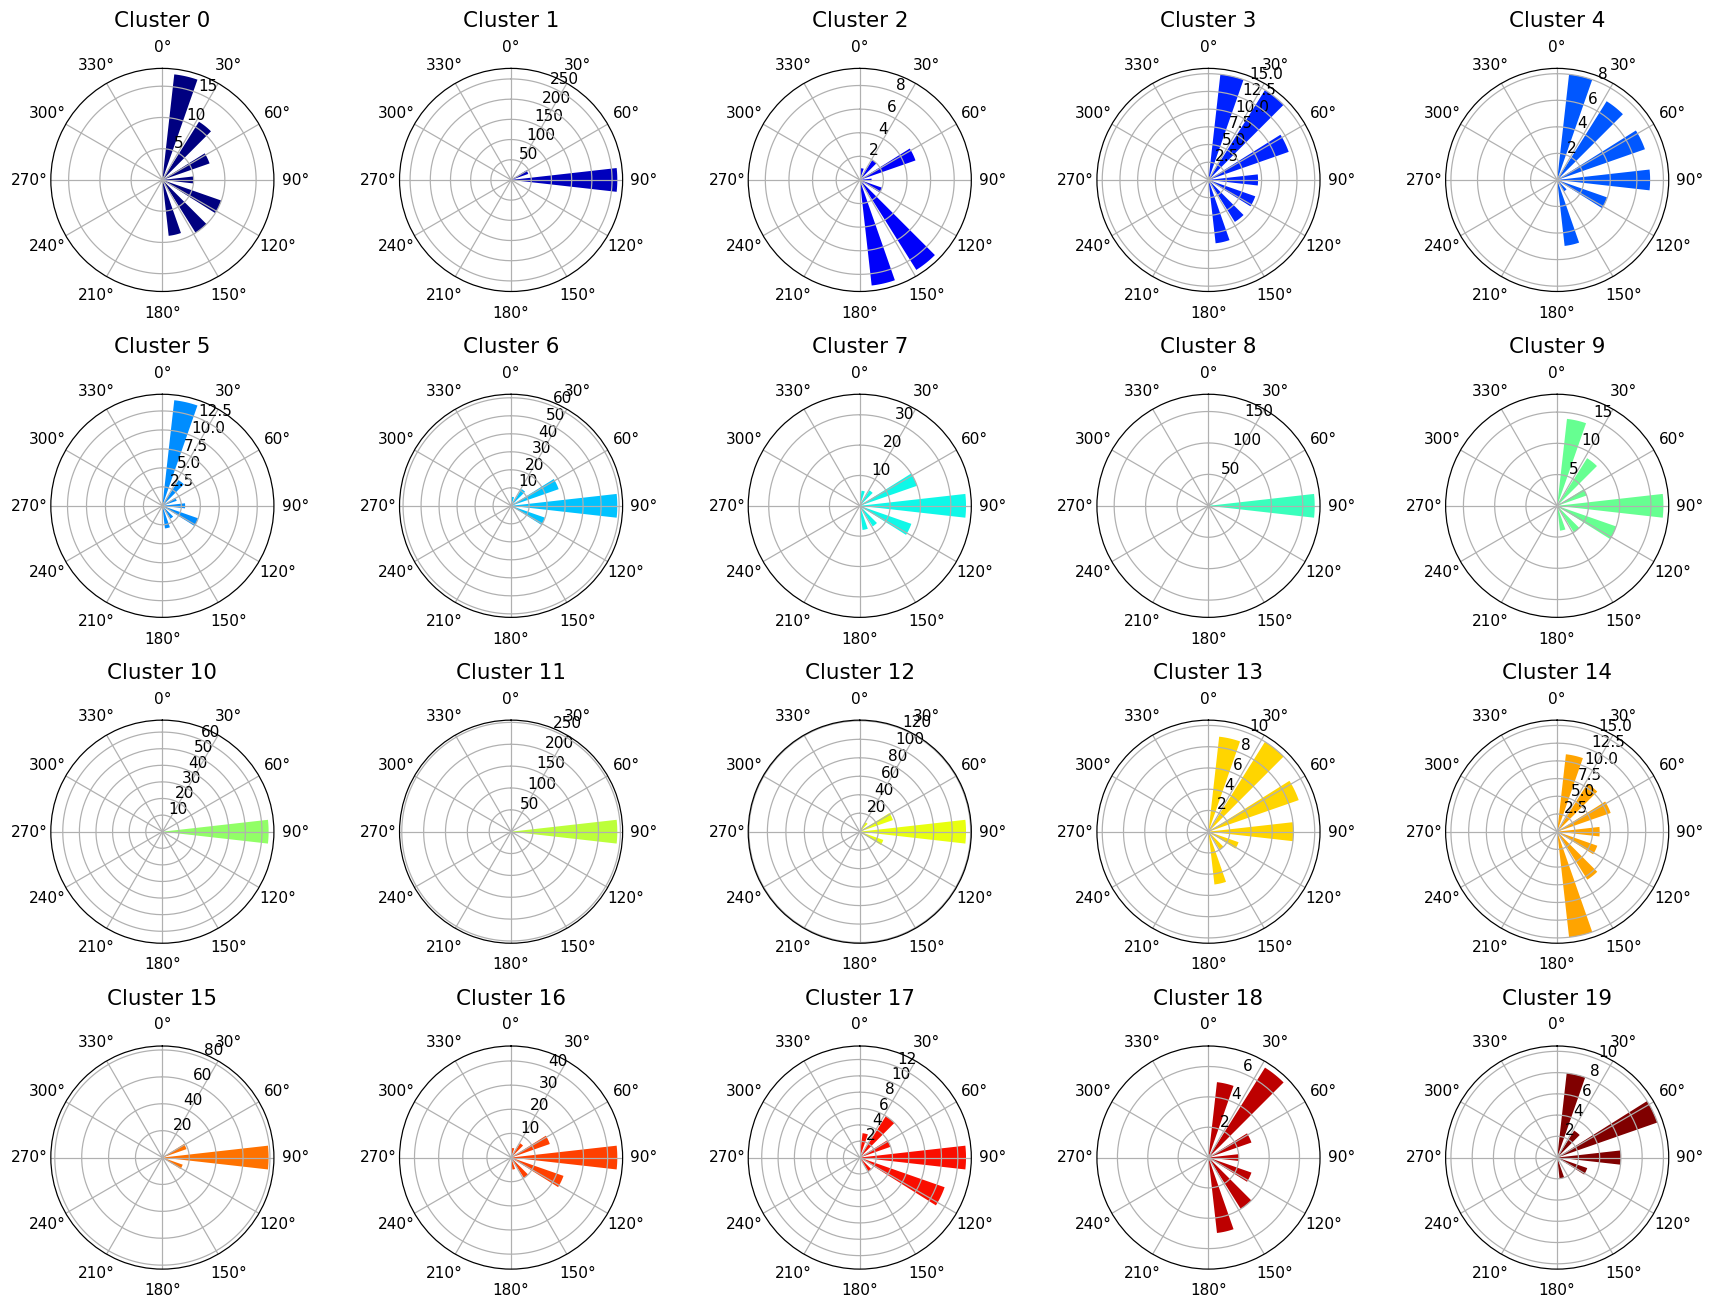

In [29]:
# Compute pie slices
mycolors =get_colors(n=nclusters, cmap_name='jet')
fig = plt.figure(figsize=(16,12), dpi=110)
for cluster in range(nclusters):
    idx = cluster + 1
    ax = plt.subplot(4,5,idx, projection='polar')
    width = 1*(2*np.pi/28) #np.pi / 16
    df = logs_nori_list[cluster]
    theta = df['theta'].values
    radii = df['frequency'].values
    colors = mycolors[cluster]

    #ax = plt.subplot(111, projection='polar')
    ax.bar(theta*np.pi/180, radii, width=width, bottom=0.0, color=colors, alpha=1)
    
    ax.set_title("Cluster {}".format(cluster),fontsize=14, pad=20)
    ax.set_thetagrids(range(0, 360, 30))
    ax.set_theta_zero_location('N')  # set direction of zero
    ax.set_theta_direction(-1) # set rotation as clockwise
fig.tight_layout()
plt.show()

In [27]:
_, dist_nori_list = compute_dfangle(basedir, results=results_list[1], sort_index=sortIndex_list[1], 
              nclusters=nclusters, topK=topK, expname=expnames[1],preprocess=True, nangle=15, debug=True)

70
320
29
72
39
33
125
100
176
64
65
250
201
46
62
118
110
39
29
32


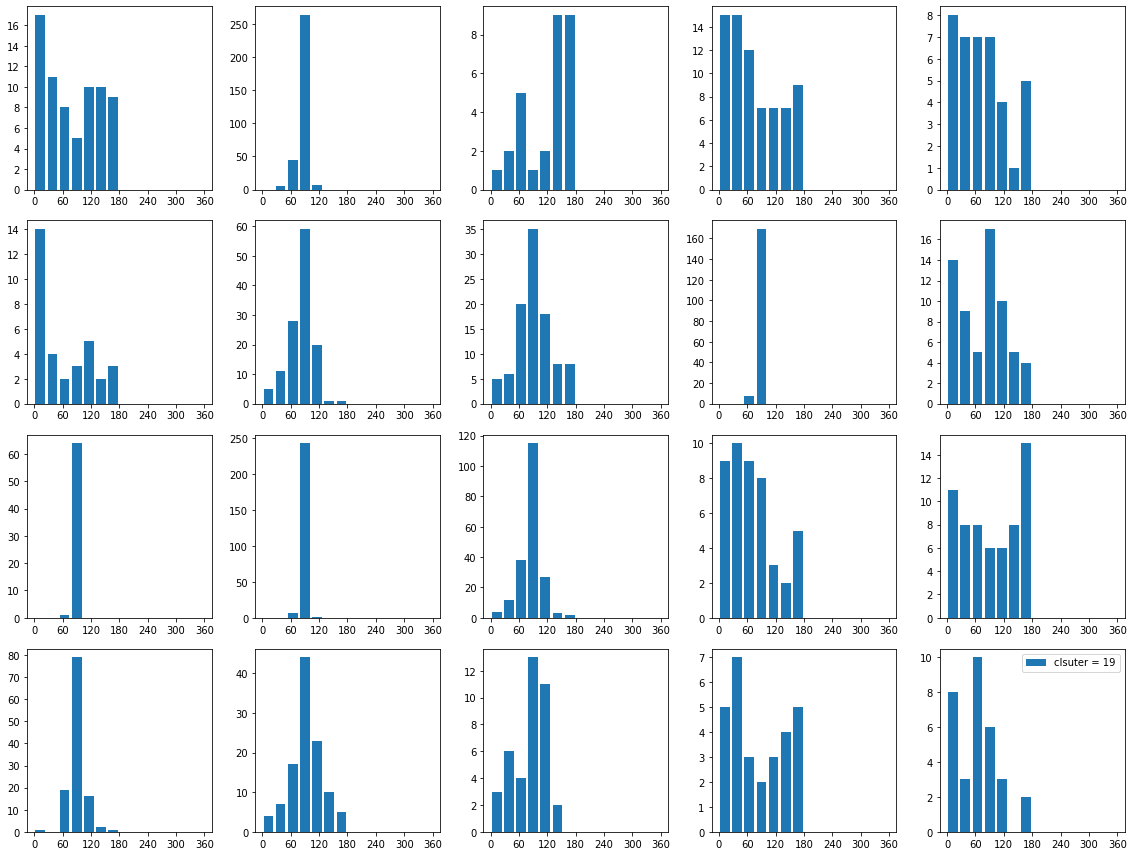

In [52]:
fig = plt.figure(figsize=(16,12))
for cluster in range(nclusters):
    idx = cluster + 1
    ax = plt.subplot(4,5,idx)
    plt.hist(dist_nori_list[cluster], bins=np.linspace(0,360,15), label="clsuter = {}".format(cluster), rwidth=0.8)
    ax.set_xticks(np.linspace(0,360,7))
plt.legend()
fig.tight_layout()
plt.show()

--------------
#### Summarize distribution of angles from different autoencoders

Procedure  
- Summarize standard deviation per cluster for each model in Dataframe  

In [30]:
def comp_dfstats(dist_list, nclusters=None,):
    """ dist_list:= distribution of angles list
    """
    stdv_list = []
    for cluster in range(nclusters):
        stdv = np.std(dist_list[cluster])
        stdv_list.append(stdv)
    return stdv_list

In [31]:
ri_stdvs = comp_dfstats(dist_ri_list, nclusters=nclusters)

In [32]:
nori_stdvs = comp_dfstats(dist_nori_list, nclusters=nclusters)

In [38]:
### cumulative i.e. sum of stdvs over nclusters
np.sum(ri_stdvs), np.sum(nori_stdvs)

(747.1966790408193, 723.4473488664686)

- Distribution of Histgram

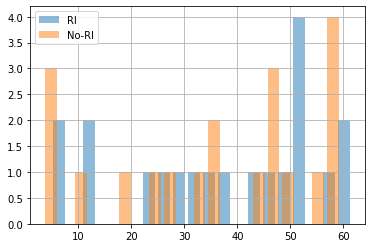

In [37]:
plt.figure()
plt.hist(ri_stdvs, alpha=0.5, rwidth=0.8, bins=nclusters, label='RI')
plt.hist(nori_stdvs, alpha=0.5, rwidth=0.8, bins=nclusters, label='No-RI')
plt.grid(True)
plt.legend()
plt.show()

- Box plot

In [58]:
df = pd.DataFrame(ri_stdvs+nori_stdvs)
df.columns = ['stdvs']
df['model'] = ['ri' for i in range(nclusters)] + ['no-ri' for i in range(nclusters)]
#fig = px.box(df, y="stdvs", x='model', color='model', points='all', )
#fig.show()

In [82]:
trace0 = go.Box(y=ri_stdvs, name='RI',boxpoints='all')
trace1 = go.Box(y=nori_stdvs, name='No-RI',boxpoints='all')
layout = dict(title = dict(text = 'Standard deviation of Principal axis in each cluster'),
              xaxis = dict(title = 'Model'),
              yaxis = dict(title = 'Standard Deviation'),
              )
fig = go.Figure()
for i in [trace0, trace1]:
    fig.add_trace(i)
fig.update_layout(
    xaxis_title=layout['xaxis']['title'],
    yaxis_title=layout['yaxis']['title'],
    font=dict(
        size=18,
    )
)
fig.show()

In [35]:
for idx, (i,j) in enumerate(zip(ri_stdvs, nori_stdvs)):
    print(idx, i,j)
np.argmax(ri_stdvs), np.argmax(nori_stdvs),np.argmin(ri_stdvs), np.argmin(nori_stdvs)

0 43.37055897053514 56.939172604792624
1 60.777267338436914 11.399085777443885
2 7.570753221806421 47.975836872974995
3 30.973888396176687 54.72614649898947
4 52.301187843071865 49.985649334403824
5 52.83502249648292 56.79837508507499
6 57.920434969960084 26.780904943515257
7 61.50583977511654 36.43640957874417
8 50.172416938025734 5.565574319609996
9 51.6934944350681 47.5239197151579
10 4.994465287035376 3.487589289646136
11 33.597859098460425 5.109751524917821
12 45.50188693940392 24.65678227658357
13 11.619659416608977 46.76003243090736
14 23.963753682593218 59.41620798118712
15 52.3463766999156 17.6066528992389
16 12.842265409944162 33.66545449746166
17 38.367560256726094 36.07714250110954
18 25.29261764610705 58.076518050502926
19 29.549370219344127 44.46014268420649


(7, 14, 10, 10)

In [112]:
def _comp_boxstats(data_list, method_names, expname):
    comp = []
    comp.append(np.mean(data_list))
    comp.append(np.quantile(data_list, 0.25))
    comp.append(np.quantile(data_list, 0.75))
    comp.append(np.max(data_list))
    comp.append(np.min(data_list))
    df = pd.DataFrame(comp).T
    df.columns = method_names
    df.index = [expname]
    return df

In [113]:
df_ri = _comp_boxstats(ri_stdvs, method_names=['Mean', 'Q1', 'Q3', 'Max', 'Min'], expname=expnames[0])

In [120]:
df_nori = _comp_boxstats(nori_stdvs, method_names=['Mean', 'Q1', 'Q3', 'Max', 'Min'], expname=expnames[1])

In [140]:
df_cop = pd.DataFrame(df_ri.iloc[0].values/df_nori.iloc[0].values *100).T
df_cop.index = ['RI/No-RI']
df_cop.columns = ['Mean', 'Q1', 'Q3', 'Max', 'Min']

In [146]:
df_all = pd.concat([df_ri, df_nori, df_cop])
df_all.index = ['RI', 'No-RI', 'RI/No-RI (%)']

In [147]:
df_all

Mean          Q1          Q3         Max         Min
RI             37.359834   24.960402   52.312485   61.505840    4.994465
No-RI          36.172367   22.894250   51.170774   59.416208    3.487589
RI/No-RI (%)  103.282800  109.024763  102.231179  103.516939  143.206808

Save image as html in notebook as online style

In [148]:
trace0 = go.Box(y=ri_stdvs, name='RI',boxpoints='all')
trace1 = go.Box(y=nori_stdvs, name='No-RI',boxpoints='all')
layout = dict(title = dict(text = 'Standard deviation of Principal axis in each cluster'),
              xaxis = dict(title = 'Model'),
              yaxis = dict(title = 'Standard Deviation'),
              )
fig = go.Figure()
for i in [trace0, trace1]:
    fig.add_trace(i)
fig.update_layout(
    xaxis_title=layout['xaxis']['title'],
    yaxis_title=layout['yaxis']['title'],
    font=dict(
        size=24,
    )
)
po.plot(fig, filename='styled-line.html')
#pio.write_image(fig, 'styled-line.png')

'styled-line.html'